In [1]:
import pandas as pd
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
import xml.etree.ElementTree as ET
import seaborn as sns

In [2]:
calendar = pd.read_csv('calendar.csv')
calendar.head()

,listing_id,date,available,price
0,10988680,2018-04-01,f,NaN
1,10988680,2018-03-31,f,NaN
2,10988680,2018-03-30,f,NaN
3,10988680,2018-03-29,f,NaN
4,10988680,2018-03-28,f,NaN


In [3]:
calendar.size

12712220

In [4]:
count = 0

for i in calendar['price']:
    if type(i) == type(0.0) and np.isnan(i):
        count = count + 1
print(count)

2091162


In [5]:
listings = pd.read_csv('listings.csv')
listings = listings.rename(columns={"id": "listing_id"})
listings.head()

c:\users\abiram\appdata\local\programs\python\python36-32\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (43) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,listing_id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,10988680,https://www.airbnb.com/rooms/10988680,20170401232214,2017-04-02,"Simple, new, clean accommodation",I signed a new lease and moving out of my plac...,"This is clean, simple, affordable accommodatio...",I signed a new lease and moving out of my plac...,none,Place is very conveniently located in the Miss...,...,10.0,f,NaN,SAN FRANCISCO,f,flexible,f,f,1,0.07
1,8053481,https://www.airbnb.com/rooms/8053481,20170401232214,2017-04-02,Spacious 2BR/2BATH w/Shared Kitchen,Enjoy the whole main floor of our sunny 2-leve...,"We love our big, bright home and we know you w...",Enjoy the whole main floor of our sunny 2-leve...,none,Our Mission District neighborhood is among the...,...,9.0,f,NaN,SAN FRANCISCO,f,strict,f,f,1,0.49
2,14011173,https://www.airbnb.com/rooms/14011173,20170401232214,2017-04-02,Private room - Victorian House in the Mission,Awesome location in the Mission District of SF...,NaN,Awesome location in the Mission District of SF...,none,NaN,...,9.0,f,NaN,SAN FRANCISCO,f,flexible,f,f,3,0.27
3,16142131,https://www.airbnb.com/rooms/16142131,20170401232214,2017-04-02,Spacious 1BR in the Mission District,"Quiet 1 bedroom apartment, with a spacious, we...",NaN,"Quiet 1 bedroom apartment, with a spacious, we...",none,NaN,...,8.0,f,NaN,SAN FRANCISCO,f,flexible,f,f,1,0.48
4,9080622,https://www.airbnb.com/rooms/9080622,20170401232214,2017-04-02,Edwardian flat in heart of Mission,Bedroom with queen bed available. The condo i...,NaN,Bedroom with queen bed available. The condo i...,none,NaN,...,NaN,f,NaN,SAN FRANCISCO,f,flexible,f,f,1,NaN


In [6]:
reviews = pd.read_csv('reviews.csv', index_col=None)
reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7025250,36355262,2015-06-27,49913,Sean,Kevin was quick to respond and very coordinati...
1,7025250,36495849,2015-06-28,17344420,Terry,"Kevin, my host, was not home but stayed in tou..."
2,7025250,40263555,2015-07-29,38552007,Jon,I have to say that after staying in 3 hotels i...
3,7025250,55069111,2015-11-27,30440816,Sean,Clean room. The room I stayed in had a privat...
4,7025250,55166030,2015-11-28,33218898,Gregg,Very relaxed and casual atmosphere. The space ...


In [7]:
listings.columns

Index(['listing_id', 'listing_url', 'scrape_id', 'last_scraped', 'name',
       'summary', 'space', 'description', 'experiences_offered',
       'neighborhood_overview', 'notes', 'transit', 'access', 'interaction',
       'house_rules', 'thumbnail_url', 'medium_url', 'picture_url',
       'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since',
       'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bat

In [8]:
prices = calendar[['listing_id', 'price']]

In [9]:
locations = listings[['listing_id', 'latitude', 'longitude']]

In [10]:
locations.head()

,listing_id,latitude,longitude
0,10988680,37.754184,-122.406514
1,8053481,37.754166,-122.421534
2,14011173,37.758506,-122.406152
3,16142131,37.756549,-122.422025
4,9080622,37.760051,-122.421352


In [11]:
listings

,listing_id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,10988680,https://www.airbnb.com/rooms/10988680,20170401232214,2017-04-02,"Simple, new, clean accommodation",I signed a new lease and moving out of my plac...,"This is clean, simple, affordable accommodatio...",I signed a new lease and moving out of my plac...,none,Place is very conveniently located in the Miss...,...,10.0,f,NaN,SAN FRANCISCO,f,flexible,f,f,1,0.07
1,8053481,https://www.airbnb.com/rooms/8053481,20170401232214,2017-04-02,Spacious 2BR/2BATH w/Shared Kitchen,Enjoy the whole main floor of our sunny 2-leve...,"We love our big, bright home and we know you w...",Enjoy the whole main floor of our sunny 2-leve...,none,Our Mission District neighborhood is among the...,...,9.0,f,NaN,SAN FRANCISCO,f,strict,f,f,1,0.49
2,14011173,https://www.airbnb.com/rooms/14011173,20170401232214,2017-04-02,Private room - Victorian House in the Mission,Awesome location in the Mission District of SF...,NaN,Awesome location in the Mission District of SF...,none,NaN,...,9.0,f,NaN,SAN FRANCISCO,f,flexible,f,f,3,0.27
3,16142131,https://www.airbnb.com/rooms/16142131,20170401232214,2017-04-02,Spacious 1BR in the Mission District,"Quiet 1 bedroom apartment, with a spacious, we...",NaN,"Quiet 1 bedroom apartment, with a spacious, we...",none,NaN,...,8.0,f,NaN,SAN FRANCISCO,f,flexible,f,f,1,0.48
4,9080622,https://www.airbnb.com/rooms/9080622,20170401232214,2017-04-02,Edwardian flat in heart of Mission,Bedroom with queen bed available. The condo i...,NaN,Bedroom with queen bed available. The condo i...,none,NaN,...,NaN,f,NaN,SAN FRANCISCO,f,flexible,f,f,1,NaN
5,936209,https://www.airbnb.com/rooms/936209,20170401232214,2017-04-02,Sunny Room w/Roofdeck @Dolores Park,Come stay in the heart of SF's best neighborho...,"Located just off 18th & Guerrero, in the safes...",Come stay in the heart of SF's best neighborho...,none,NaN,...,9.0,f,NaN,SAN FRANCISCO,f,moderate,f,f,1,1.27
6,7048973,https://www.airbnb.com/rooms/7048973,20170401232214,2017-04-02,Boutique Condo in the Mission,Boutique condo in the heart of the vibrant Mis...,NaN,Boutique condo in the heart of the vibrant Mis...,none,NaN,...,9.0,f,14755773,SAN FRANCISCO,f,strict,f,f,1,0.35
7,7998215,https://www.airbnb.com/rooms/7998215,20170401232214,2017-04-02,Pretty & Relaxing Bedroom with Bathroom,"Quiet one bedroom, one bath with all the ameni...",NaN,"Quiet one bedroom, one bath with all the ameni...",none,"We are located in the middle of the Mission, w...",...,10.0,f,STR-0000735,SAN FRANCISCO,f,strict,f,f,2,2.56
8,12815115,https://www.airbnb.com/rooms/12815115,20170401232214,2017-04-02,Spacious Mission Condo,"Built in 2014, this modern penthouse's 3 porch...",NaN,"Built in 2014, this modern penthouse's 3 porch...",none,NaN,...,NaN,f,NaN,SAN FRANCISCO,f,flexible,f,f,2,NaN
9,10406646,https://www.airbnb.com/rooms/10406646,20170401232214,2017-04-02,Bright Skylight-Filled 2 Bedroom in the Mission,Located in a residential part of the Mission d...,Located in a residential part of the Mission d...,Located in a residential part of the Mission d...,none,NaN,...,9.0,f,NaN,SAN FRANCISCO,f,moderate,f,f,3,2.77


In [12]:
combined = pd.merge(prices, locations, how='inner', on=['listing_id']).dropna()
combined['price'] = [float(x[1:].replace(',', '')) for x in combined['price']]

In [13]:
combined

,listing_id,price,latitude,longitude
526,8053481,220.0,37.754166,-122.421534
527,8053481,220.0,37.754166,-122.421534
536,8053481,230.0,37.754166,-122.421534
537,8053481,220.0,37.754166,-122.421534
538,8053481,220.0,37.754166,-122.421534
539,8053481,220.0,37.754166,-122.421534
540,8053481,220.0,37.754166,-122.421534
541,8053481,220.0,37.754166,-122.421534
542,8053481,230.0,37.754166,-122.421534
543,8053481,230.0,37.754166,-122.421534


In [14]:
min_lat = combined['latitude'].min()
max_lat = combined['latitude'].max()
print(min_lat)
print(max_lat)

37.7069276929
37.8310927851


In [15]:
min_long = combined['longitude'].min()
max_long = combined['longitude'].max()
print(min_long)
print(max_long)

-122.51149999
-122.365221992


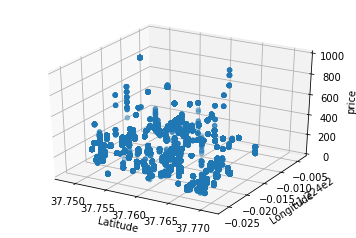

In [16]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

lat_coord = combined['latitude'][:30000]
long_coord = combined['longitude'][:30000]
price_coord = combined['price'][:30000]

ax.scatter(lat_coord, long_coord, price_coord)
ax.set_zlim([0, 1000])
ax.set_xlabel('Latitude')
ax.set_ylabel('Longitude')
ax.set_zlabel('price')

plt.show()

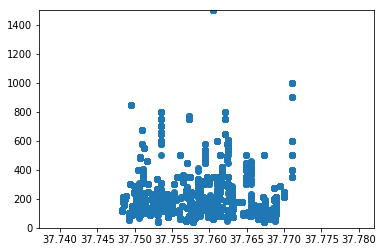

In [19]:
lat_x = combined['latitude'][:30000]
lat_y = combined['price'][:30000]

plt.scatter(lat_x, lat_y)
plt.ylim([0, 1500])
plt.show()

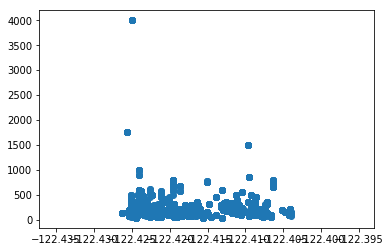

In [21]:
long_x = combined['longitude'][:30000]
long_y = combined['price'][:30000]

plt.scatter(long_x, long_y)
#plt.ylim([0, 1500])
plt.show()

In [23]:
x_train = combined[['latitude', 'longitude']][1:30000]
y_train = combined['price'][1:30000]

ols = linear_model.LinearRegression()
model = ols.fit(x_train, y_train)

In [24]:
model

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [25]:
model.intercept_

-1558960.7418219633

In [26]:
model.coef_

array([ -7204.37864921, -14959.0245567 ])

In [28]:
x_test = combined[['latitude', 'longitude']][30001:60000]
y_test = combined['price'][30001:60000]

y_pred = model.predict(x_test)
print(mean_squared_error(y_test, y_pred))
print(r2_score(y_test, y_pred))

41950.0621783
-0.154426650816


In [29]:
listings.columns

Index(['listing_id', 'listing_url', 'scrape_id', 'last_scraped', 'name',
       'summary', 'space', 'description', 'experiences_offered',
       'neighborhood_overview', 'notes', 'transit', 'access', 'interaction',
       'house_rules', 'thumbnail_url', 'medium_url', 'picture_url',
       'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since',
       'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bat

In [30]:
size_rating = listings[['listing_id', 'square_feet', 'review_scores_rating']].dropna()
print(size_rating.size)
size_rating.head()

531


,listing_id,square_feet,review_scores_rating
35,63405,500.0,93.0
65,815123,170.0,100.0
115,58756,600.0,100.0
124,273452,1100.0,95.0
132,470686,950.0,98.0


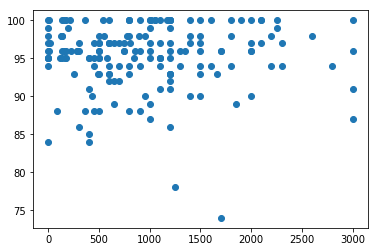

In [31]:
plt.scatter(size_rating['square_feet'], size_rating['review_scores_rating'])
plt.show()

In [32]:
price_ratings = listings[['listing_id', 'price', 'review_scores_rating']].dropna()
print(price_ratings.size)
price_ratings.head()

19965


,listing_id,price,review_scores_rating
0,10988680,$49.00,100.0
1,8053481,$220.00,96.0
2,14011173,$100.00,90.0
3,16142131,$117.00,100.0
5,936209,$162.00,96.0


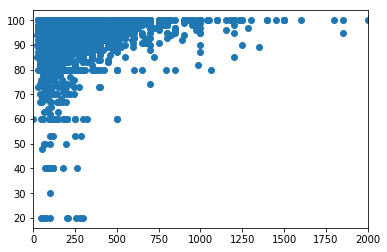

In [33]:
price_ratings['price'] = [float(x[1:].replace(',','')) for x in price_ratings['price']]
plt.scatter(price_ratings['price'], price_ratings['review_scores_rating'])
plt.xlim([0, 2000])
plt.show()

In [34]:
bedroom_price = listings[['listing_id', 'bedrooms', 'price']].dropna()
print(bedroom_price.size)
bedroom_price.head()

26094


,listing_id,bedrooms,price
0,10988680,1.0,$49.00
1,8053481,2.0,$220.00
2,14011173,1.0,$100.00
3,16142131,1.0,$117.00
4,9080622,1.0,$200.00


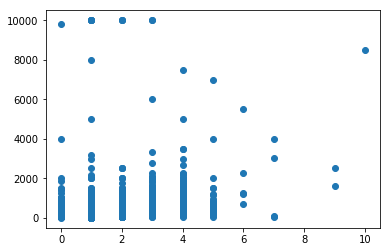

In [35]:
bedroom_price['price'] = [float(x[1:].replace(',','')) for x in bedroom_price['price']]
plt.scatter(bedroom_price['bedrooms'], bedroom_price['price'])
plt.show()

In [36]:
size_price = listings[['listing_id', 'square_feet', 'price']].dropna()
size_price['price'] = [float(x[1:].replace(',','')) for x in size_price['price']]
print(size_price.size)
size_price.head()

552


,listing_id,square_feet,price
35,63405,500.0,125.0
65,815123,170.0,130.0
75,223213,1100.0,450.0
94,486950,1400.0,100.0
115,58756,600.0,127.0


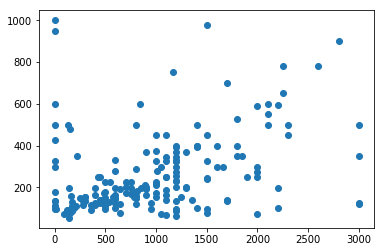

In [37]:
# try and see if there is a relationship between size of place and the price of it.
plt.scatter(size_price['square_feet'], size_price['price'])
plt.show()

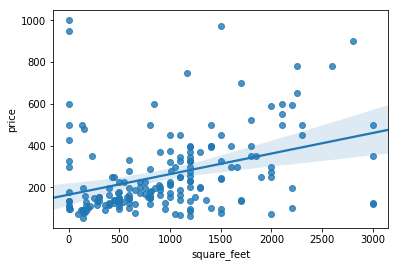

In [38]:
sns.regplot(x='square_feet', y='price', data=size_price)
plt.show()

In [39]:
x_train = size_price['square_feet']
y_train = size_price['price']

ols = linear_model.LinearRegression()
model = ols.fit(x_train.values.reshape(-1,1), y_train)
print("intercept: ", model.intercept_, "slope: ", model.coef_[0])
y_pred = model.predict(x_train.values.reshape(-1,1))
print("mean squared error: ", mean_squared_error(y_train, y_pred))
print("r^2 value: ", r2_score(y_train, y_pred))

intercept:  165.362043425 slope:  0.0985059258354
mean squared error:  30101.8244725
r^2 value:  0.136046441209


In [40]:
listings.columns

Index(['listing_id', 'listing_url', 'scrape_id', 'last_scraped', 'name',
       'summary', 'space', 'description', 'experiences_offered',
       'neighborhood_overview', 'notes', 'transit', 'access', 'interaction',
       'house_rules', 'thumbnail_url', 'medium_url', 'picture_url',
       'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since',
       'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bat